In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import loompy as lp

import numpy as np
import pandas as pd
import re

import os

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

In [2]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [5]:
os.chdir("/research/peer/fdeckert/FD20200109SPLENO")

# Parameter

In [ ]:
combine_loom = False

# Import meta data 

In [ ]:
meta = pd.read_csv('meta.csv')

# Manipulate and combine velocyto loom files

## Correct loom files cell ID

In [ ]:
def loom_cellid(meta_row):
    
    """Removes velocyto pattern from cell ids if present"""
    
    # Open connection to loom file 
    ds = lp.connect(meta_row['sample_path'] + '/velocyto.loom')
    
    # Change velocyto cell id to original id 
    cell_id = ds.ca['CellID'] # np.array 
    cell_id = pd.Series(cell_id)
    
    # Remove velocyto extension and add sample cell id idx 
    if bool(re.search('x', cell_id[0])): 

        cell_id = cell_id.str.split(':').str.get(1) # Cut after file name appendix
        cell_id = cell_id.str.split('x').str.get(0) # Remove tailing x
        cell_id = cell_id + "-1_" + str(meta_row['cell_id_idx']) # cell id idx from seurat merge
        ds.ca['CellID'] = np.array(cell_id) # replace cellid 
        
    else:
        
        print(meta_row['sample_path'] + ' no velocyto cell id detected. Leaving untouched')
    
    # Close loom connection 
    ds.close()
    
    # Nothing to return 
    pass
    
connect = meta.apply(loom_cellid, axis=1)

## Combine loom files

In [ ]:
if combine_loom: 
    lp.combine(list(meta['sample_path'] + '/velocyto.loom'), 'data/loom_object/loom_velocyto.loom', key = 'Accession')

# Combine velocyto with seurat data

## Import seurat h5ad

In [ ]:
# Import Seurat h5ad as anndata
adata_seurat = sc.read_h5ad("data/h5ad_object/h5ad_qc.h5ad")
if not adata_seurat.var_names.is_unique: adata_seurat.var_names_make_unique()

## Import velocyto loom 

In [ ]:
# Import velocyto loom as anndata
adata = scv.read_loom('data/loom_object/loom_velocyto.loom')
if not adata.var_names.is_unique: adata.var_names_make_unique()
    
scv.pp.filter_and_normalize(adata, min_shared_counts=20)

## Transfer obs from seurat to velocyto anndata

In [ ]:
adata.obs = adata.obs.merge(adata_seurat.obs, left_index=True, right_index=True)

## Save combined anndata and relode to set categories 

In [ ]:
# Write combined velocyto/seurat h5ad 
adata.write_h5ad('data/h5ad_object/h5ad_velocyto.h5ad')
adata = sc.read_h5ad('data/h5ad_object/h5ad_velocyto.h5ad') # Will convert meta to categories

# Proportions 

In [ ]:
scv.pl.proportions(adata, groupby='sample_name')

# Normalization 

In [ ]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30, use_highly_variable=False)

In [ ]:
scv.tl.recover_dynamics(adata, n_jobs=8)

In [ ]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

In [ ]:
# adata.write('data/h5ad_object/h5ad_scvelo.h5ad')
adata = sc.read_h5ad('data/h5ad_object/h5ad_scvelo.h5ad')

computing velocity embedding
    finished (0:00:18) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


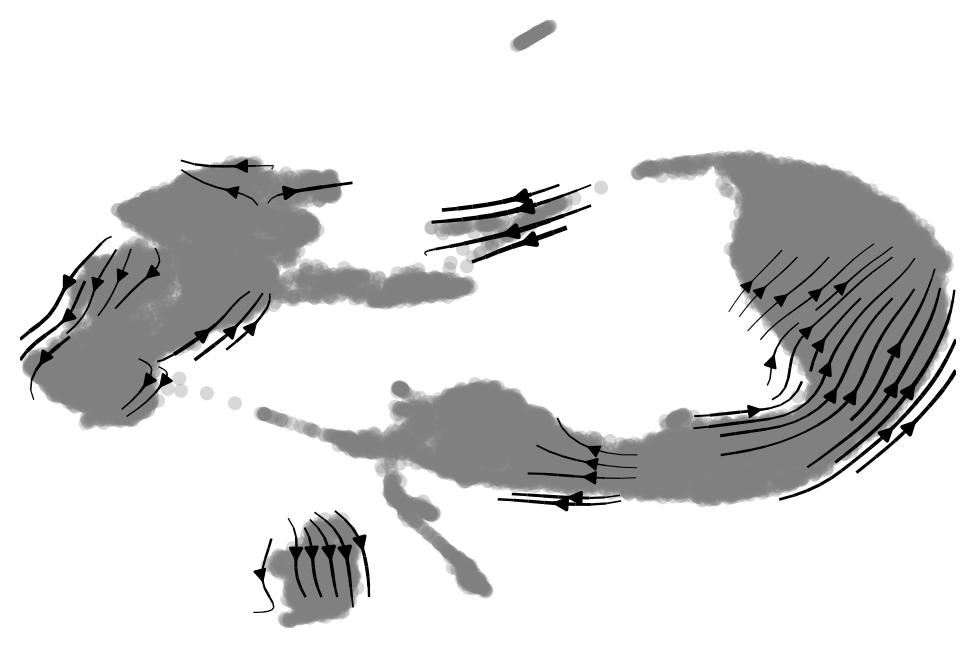

In [10]:
scv.tl.umap(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap', legend_fontsize=12, title='', smooth=.8, min_mass=4)